## JVM Thread Dump Analysis
Inspired by: https://github.com/jakevdp/JupyterWorkflow

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn')

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import jvmthreadparser.parser as jtp

### Get Data

In [3]:
dump = jtp.open_text('threads4.txt', load_thread_content = False)

In [4]:
dump.head()

,DateTime,State
0,2017-04-30 01:02:01,RUNNABLE
1,2017-04-30 01:02:01,WAITING (ON OBJECT MONITOR)
2,2017-04-30 01:02:01,TIMED_WAITING (PARKING)
3,2017-04-30 01:02:01,TIMED_WAITING (PARKING)
4,2017-04-30 01:02:01,TIMED_WAITING (PARKING)


### Thread State by Date

In [5]:
dump['Threads'] = 1
threads_by_state = dump.groupby(['DateTime','State']).count().unstack().fillna(0)
threads_by_state.columns = threads_by_state.columns.droplevel()
threads_by_state.head()

State,BLOCKED (ON OBJECT MONITOR),RUNNABLE,TERMINATED,TIMED_WAITING (ON OBJECT MONITOR),TIMED_WAITING (PARKING),TIMED_WAITING (SLEEPING),WAITING (ON OBJECT MONITOR),WAITING (PARKING)
DateTime,,,,,,,,
2017-04-30 01:02:01,0.0,27.0,0.0,54.0,136.0,3.0,4.0,0.0
2017-04-30 01:04:01,0.0,31.0,0.0,54.0,131.0,3.0,4.0,0.0
2017-04-30 01:06:01,0.0,26.0,0.0,55.0,113.0,3.0,4.0,10.0
2017-04-30 01:08:01,0.0,25.0,0.0,55.0,114.0,3.0,4.0,10.0
2017-04-30 01:10:01,0.0,28.0,0.0,54.0,112.0,3.0,4.0,10.0


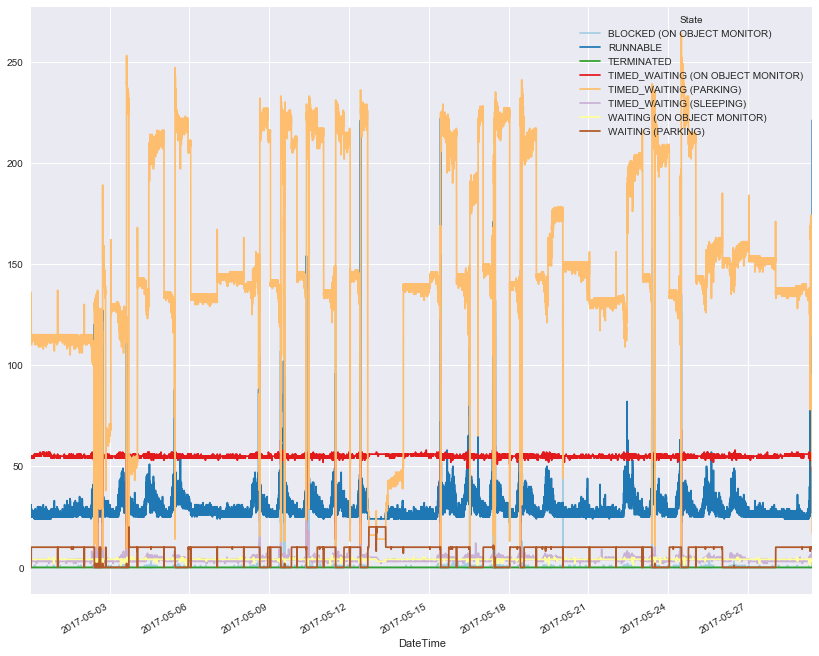

In [6]:
threads_by_state.plot(figsize=(14,12), cmap='Paired');

### Average of Threads by Hour

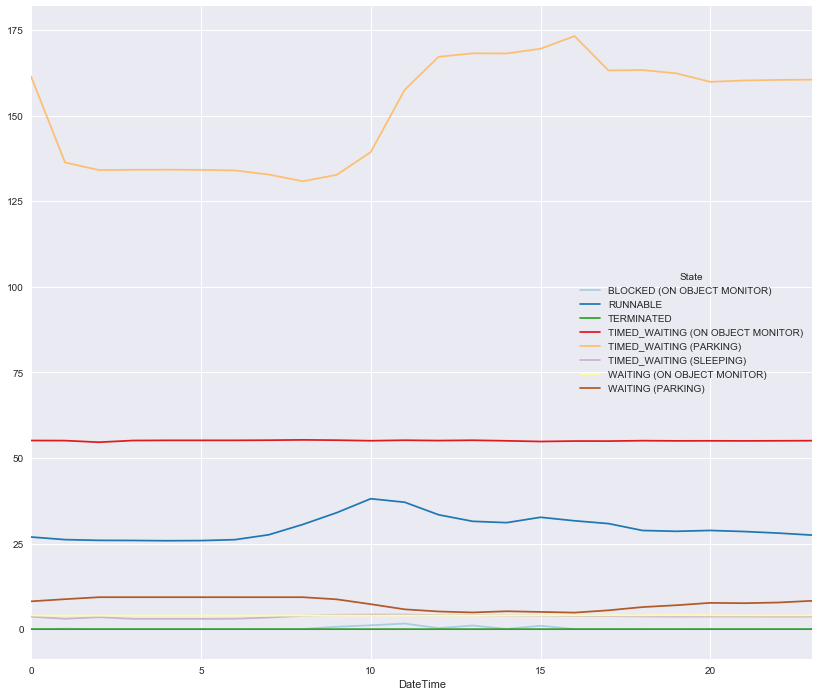

In [7]:
threads_by_state.groupby(threads_by_state.index.hour).mean().plot(figsize=(14,12), cmap='Paired');

### Average of Threads by Day

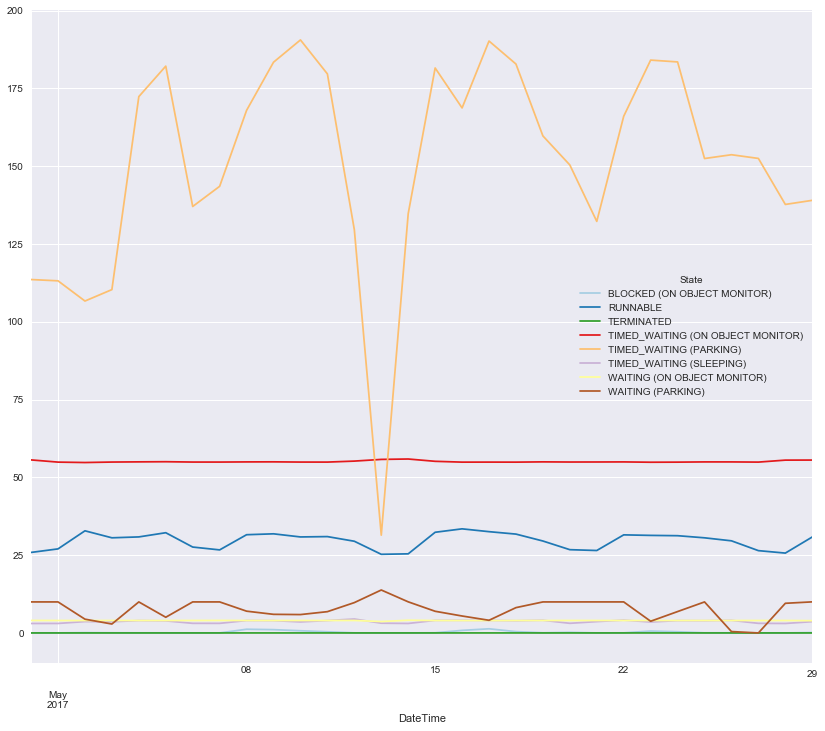

In [8]:
threads_by_state.resample('D').mean().plot(figsize=(14,12), cmap = 'Paired');

### Threads in TIMED_WAITING (PARKING) by Hour Each Day

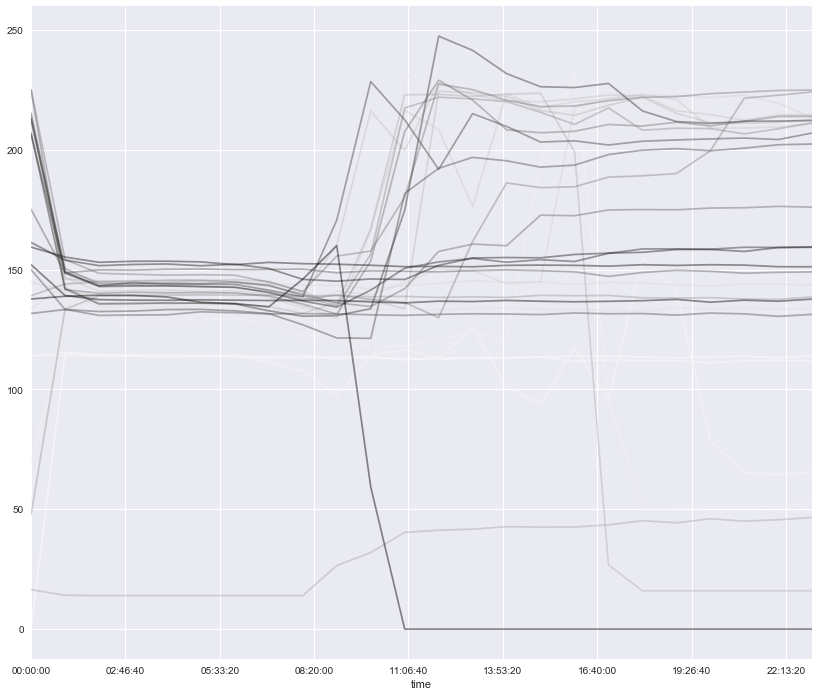

In [9]:
by_hour = threads_by_state.resample('H').mean()
pivoted = by_hour.pivot_table("TIMED_WAITING (PARKING)", index = by_hour.index.time, columns = by_hour.index.date).fillna(0)
pivoted.plot(legend=False, alpha = 0.45, cmap = 'Greys', figsize=(14,12));

### Principal Component Analysis

In [10]:
X = pivoted.fillna(0).T.values
X.shape

(30, 24)

In [11]:
X2 = PCA(3, svd_solver='full').fit_transform(X)
X2.shape

(30, 3)

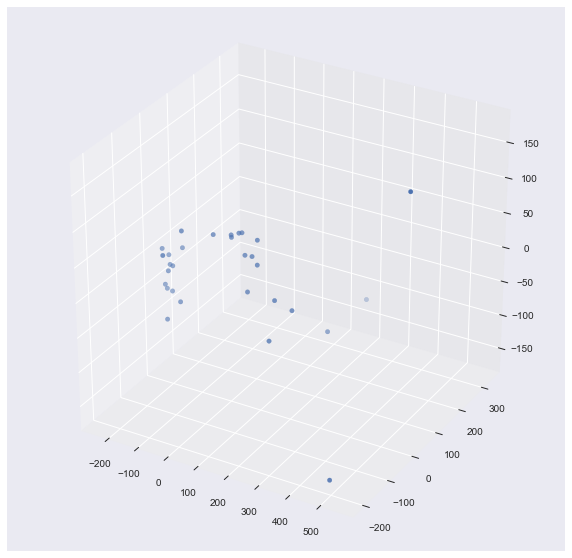

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X2[:, 0], X2[:, 1], X2[:, 2]);

### Unsupervised Clustering

In [13]:
gmm = GaussianMixture(3).fit(X)
labels = gmm.predict(X)

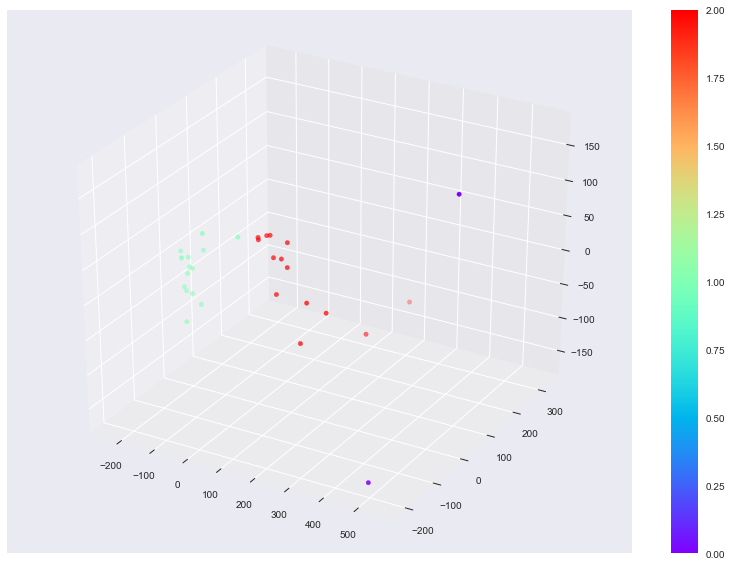

In [14]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X2[:, 0], X2[:, 1], X2[:, 2], c=labels, cmap='rainbow')
fig.colorbar(p);

### Visualizing Clustering

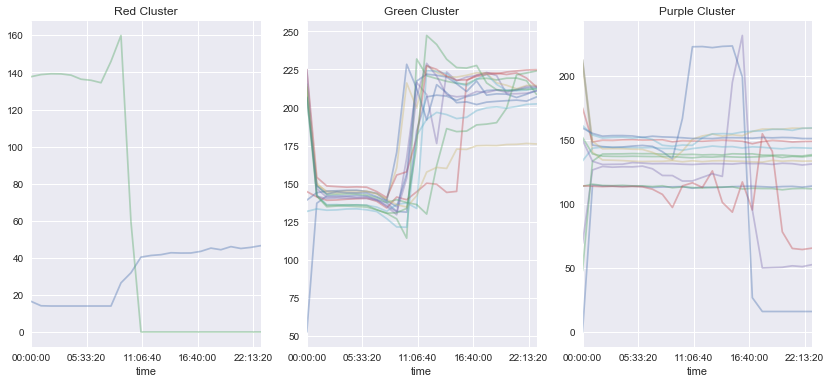

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

pivoted.T[labels == 0].T.plot(legend=False, alpha=0.4, ax=ax[0]);
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.4, ax=ax[1]);
pivoted.T[labels == 2].T.plot(legend=False, alpha=0.4, ax=ax[2]);

ax[0].set_title('Red Cluster')
ax[1].set_title('Green Cluster');
ax[2].set_title('Purple Cluster');

### Comparing with Day of Week

In [16]:
dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek

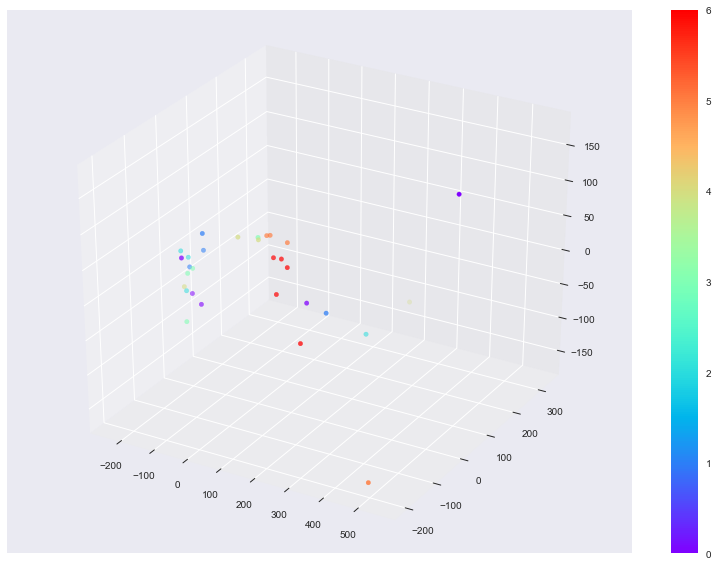

In [17]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X2[:, 0], X2[:, 1],  X2[:, 2], c=dayofweek, cmap='rainbow')
fig.colorbar(p);